In [ ]:
# Imports
import pandas as pd
from dotenv import load_dotenv
import os
import csv
import spacy 
import time
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Data processing (Task 1)

In [20]:
load_dotenv()
filepath = os.getenv('FILEPATH')

In [ ]:

"""
The corpus is formatted as a CSV and contains the following fields:

    id
    domain
    type
    url
    content
    scraped_at
    inserted_at
    updated_at
    title
    authors
    keywords
    meta_keywords
    meta_description
    tags
    summary
    source (opensources, nytimes, or webhose)
"""
csv.field_size_limit(100000000)


selected_columns = ["domain", "title", "authors", "type", "content", "url"]
sample_chunks = []
for chunk in pd.read_csv(filepath, usecols=selected_columns, chunksize=100000, on_bad_lines='warn', engine='python'):
    sample = chunk.sample(frac=0.1, random_state=42)
    sample_chunks.append(sample)
    df = pd.concat(sample_chunks, ignore_index=True)

train_dataframe, temp_dataframe = train_test_split(df, test_size=0.2, random_state=42) # 80% for training and temp for validation and testing
validation_dataframe, test_dataframe = train_test_split(temp_dataframe, test_size=0.5, random_state=42) # splitting the temp data into 10% for validation and 10% for testing

train_dataframe.to_csv("data/train_data.csv", chunksize=100000)
validation_dataframe.to_csv("data/validation_data.csv", chunksize=100000)
test_dataframe.to_csv("data/test_data.csv", chunksize=100000)

In [ ]:
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"]) # https://www.geeksforgeeks.org/tokenization-using-spacy-library/
output_file = "processed_data.txt"
selected_columns = ["domain", "title", "authors", "type", "content", "url"]

# counter info https://www.geeksforgeeks.org/python-counter-objects-elements/
lemmatized_vocab_counter = Counter() # number of lemmatized words without stopwords 
stopword_counter = Counter() 
filtered_vocab_counter = Counter() # number of words without stopwords
original_vocab = set()

# I used chatgpt here for understanding how to use spacy and processing the texts in batches
# spacy docs: https://spacy.io/usage/processing-pipelines 
def preprocess(texts):
    for doc in nlp.pipe(texts, batch_size=500, n_process=4): # batch size is the number of texts to process at once

        for token in doc: # token is a single word/punctuation in a list of tokens
            if token.is_alpha: # check if token is a word
                original_vocab.add(token.text.lower())
                word = token.text.lower()
                if (token.is_stop): # if the token is a stopwword, add to counter
                    stopword_counter[word] += 1
                else: # otherwise update the filtered vocab counter and lemmatized vocab counter
                    filtered_vocab_counter[word] += 1
                    lemmatized_vocab_counter[token.lemma_.lower()] += 1 
        
        yield " ".join(token.lemma_.lower() for token in doc if token.is_alpha and not token.is_stop)

input_files = ["data/train_data.csv", "data/validation_data.csv", "data/test_data.csv"]
output_files = ["data/processed_train.csv", "data/processed_validation.csv", "data/processed_test.csv"]

for input_file, output_file in zip(input_files, output_files):
    print(f"Processing {input_file}")
    first_chunk = True

    # writing the processed text data into another file
    with open(output_file, "w", encoding="utf-8") as f_out: 
        for chunk in tqdm(pd.read_csv(input_file, encoding="utf-8", usecols=selected_columns, on_bad_lines='warn', chunksize=1024, engine='python')):
            start = time.time() # timing the chunk processing for debugging

            # adding label column which tells whether the article is reliable (=1) or not (=0)
            chunk["label"] = chunk["type"].apply(lambda x: 1 if str(x).strip().lower() == "reliable" else 0)
            # collecting yields into a list
            texts = chunk["content"].fillna("").astype(str).tolist() # content column to a list
            processed = list(preprocess(texts)) # processing the list
            chunk["processed_text"] = processed # assigning back to chunk

            print(f"Chunk processed in {time.time() - start:.2f}s")
            # appending the chunk to the output file
            chunk[["processed_text", "label", "type", "domain", "title", "url", "authors"]].to_csv(f_out, mode="a", header=first_chunk, index=False) 
            first_chunk = False # for the header 


print("Preprocessing done.")

Processing data/train_data.csv
Chunk processed in 47.11s
Chunk processed in 31.46s
Chunk processed in 31.04s
Chunk processed in 28.70s
Chunk processed in 30.57s
Chunk processed in 32.19s
Chunk processed in 32.62s
Chunk processed in 32.15s
Chunk processed in 32.07s
Chunk processed in 28.98s
Processing data/test_data.csv
Chunk processed in 32.71s
Chunk processed in 32.55s
Chunk processed in 33.37s
Chunk processed in 33.60s
Chunk processed in 34.37s
Chunk processed in 33.20s
Chunk processed in 34.06s
Chunk processed in 32.37s
Chunk processed in 33.58s
Chunk processed in 29.06s
Preprocessing done.


In [ ]:
df_train = pd.read_csv("data/processed_train.csv")  
df_valid = pd.read_csv("data/processed_validation.csv")
df_test = pd.read_csv("data/processed_test.csv")  

### Computing reduction rates

In [ ]:

original_vocab_size = len(original_vocab) 
filtered_vocab_size = len(filtered_vocab_counter)
lemmatized_vocab_size = len(lemmatized_vocab_counter)

# reduction rate after stopword removal
stopword_reduction_rate = ((original_vocab_size - filtered_vocab_size) / original_vocab_size) * 100

# calculating elmamtized reduction rate
lemmatized_reduction_rate = ((filtered_vocab_size - lemmatized_vocab_size) / filtered_vocab_size) * 100

print(f"Original vocabulary size: {original_vocab_size}")
print(f"Vocabulary size after removing stopwords: {filtered_vocab_size}")
print(f"Vocabulary size after lemmatization: {lemmatized_vocab_size}")
print(f"Stopword reduction rate: {stopword_reduction_rate:.2f}%")
print(f"lemmatized reduction rate: {lemmatized_reduction_rate:.2f}%")

with open("data/preprocessing_stats.txt", "w", encoding="utf-8") as f:
    f.write(f"Original vocabulary size: {original_vocab_size}\n")
    f.write(f"Vocabulary size after removing stopwords: {filtered_vocab_size}\n")
    f.write(f"Vocabulary size after lemmatization: {lemmatized_vocab_size}\n")
    f.write(f"Stopword reduction rate: {stopword_reduction_rate:.2f}%\n")
    f.write(f"Lemmatized reduction rate: {lemmatized_reduction_rate:.2f}%\n")

print(df_train.head()) 



NameError: name 'original_vocab' is not defined

### Exploring train data (task 2)

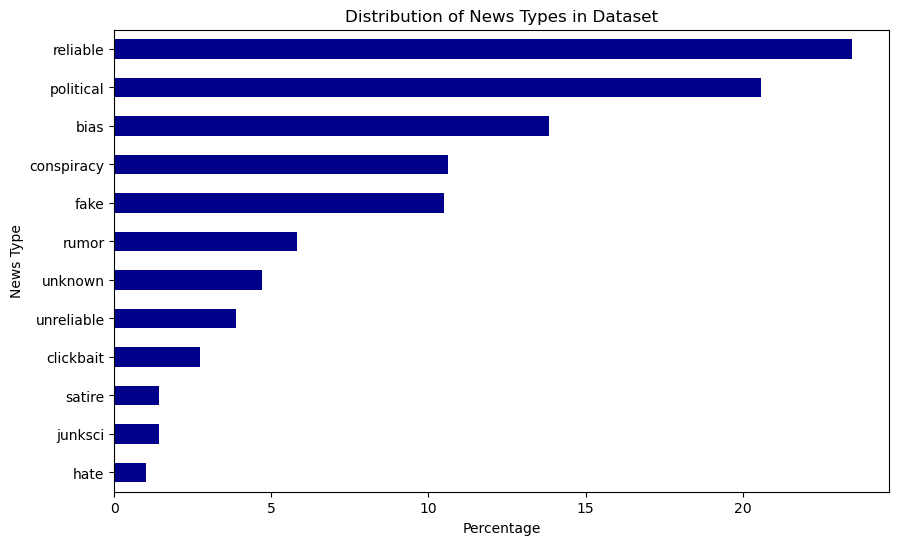

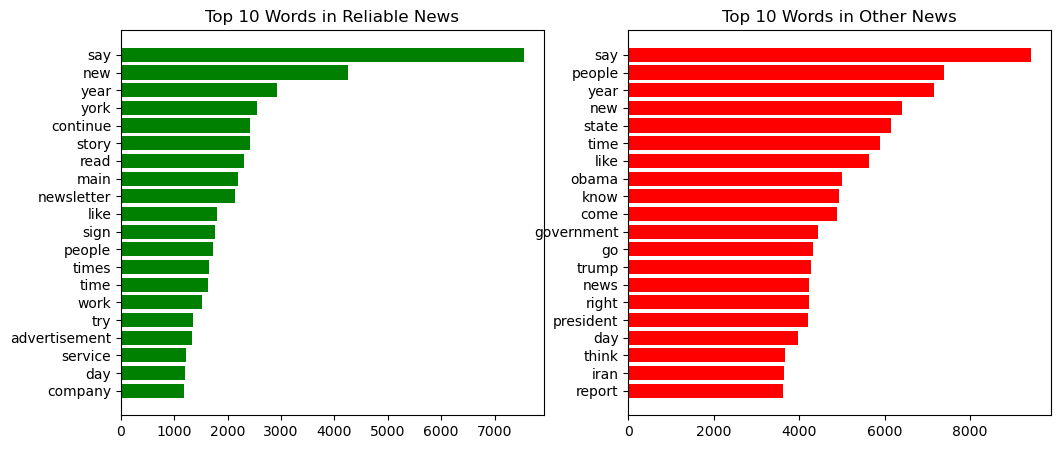

In [5]:
   
# Precentage distribution of labels in the datasetr
type_distribution = df_train["type"].value_counts(normalize=True) * 100 # counting the distribution
type_distribution.sort_values().plot(kind="barh", figsize=(10, 6), color="darkblue") # plotting a horizontal bar

plt.xlabel("Percentage")
plt.ylabel("News Type")
plt.title("Distribution of News Types in Dataset")
plt.show()

# visualizing the distribution of words in reliable vs non-reliable news
reliable_texts = df_train[df_train["label"] == 1]["processed_text"].dropna().astype(str)
other_texts = df_train[df_train["label"] != 1]["processed_text"].dropna().astype(str)

reliable_counter = Counter(" ".join(reliable_texts).split())
other_counter = Counter(" ".join(other_texts).split())

# counting the top 10 words in reliable and other news
reliable_top10 = reliable_counter.most_common(20)
other_top10 = other_counter.most_common(20)

# unzipping the word and count pairs
words_r, counts_r = zip(*reliable_top10) # https://www.w3schools.com/python/ref_func_zip.asp
words_o, counts_o = zip(*other_top10)

plt.figure(figsize=(12, 5))

# Plot reliable
plt.subplot(1, 2, 1)
plt.barh(words_r[::-1], counts_r[::-1], color="green")
plt.title("Top 10 Words in Reliable News")

# Plot other
plt.subplot(1, 2, 2)
plt.barh(words_o[::-1], counts_o[::-1], color="red")
plt.title("Top 10 Words in Other News")

plt.show()

# Avanced model

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

### Training the model

In [ ]:
x_train = df_train["processed_text"].fillna("").astype(str).tolist()
y_train = df_train["label"].values

MAX_WORDS=10000
MAX_LEN=100
LSTM_UNITS=64
NUM_CLASSES=1 # 1 class bc its binary classification

# reference: https://spotintelligence.com/2023/01/11/lstm-in-nlp-tasks/
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(x_train)
sequences = tokenizer.texts_to_sequences(x_train)

# padding sequences make all sequences the same length
xTrain = pad_sequences(sequences, maxlen=MAX_LEN, padding='post')



In [27]:
# Building the model
model = Sequential()
model.add(Embedding(MAX_WORDS, 32))
model.add(LSTM(LSTM_UNITS))
model.add(Dense(NUM_CLASSES, activation='sigmoid'))

In [28]:
# Compiling model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# training the model
model.fit(xTrain, y_train, batch_size=32, epochs=10)

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.8006 - loss: 0.5033
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.8682 - loss: 0.3409
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.8394 - loss: 0.3324
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.8639 - loss: 0.3134
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.9340 - loss: 0.1956
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.9482 - loss: 0.1572
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.9477 - loss: 0.1578
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.9364 - loss: 0.1711
Epoch 9/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.9587 - loss: 0.1351
Epoch 10/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.9716 - loss: 0.0960


### Validating

In [35]:
x_valid = df_test["processed_text"].fillna("").astype(str).tolist()
y_valid = df_test["label"].values

sequences = tokenizer.texts_to_sequences(x_valid)
# padding sequences make all sequences the same length
xValid = pad_sequences(sequences, maxlen=MAX_LEN, padding='post')

# predictions
y_pred_probs = model.predict(xValid)
y_pred = (y_pred_probs >= 0.5).astype(int).flatten() 

# evaluation
print(classification_report(y_valid, y_pred))

print("Accuracy:", accuracy_score(y_valid, y_pred))
print("Precision:", precision_score(y_valid, y_pred))
print("Recall:", recall_score(y_valid, y_pred))
print("F1-score:", f1_score(y_valid, y_pred))


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
              precision    recall  f1-score   support

           0       0.77      0.89      0.82      7655
           1       0.27      0.14      0.19      2345

    accuracy                           0.71     10000
   macro avg       0.52      0.51      0.51     10000
weighted avg       0.65      0.71      0.67     10000

Accuracy: 0.7114
Precision: 0.27477102414654453
Recall: 0.14072494669509594
F1-score: 0.18612521150592218


### Evaluating the model

In [ ]:
x_test = df_test["processed_text"].fillna("").astype(str).tolist()
y_test = df_test["label"].values

sequences = tokenizer.texts_to_sequences(x_test)

# padding sequences make all sequences the same length
xTest = pad_sequences(sequences, maxlen=MAX_LEN, padding='post')

loss, accuracy = model.evaluate(xTest, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6816 - loss: 1.0827
Test Loss: 1.0726
Test Accuracy: 0.6839
